This notebook shows how to read the fastMRI Prostate dataset and reconstruct T2 and DW images

To download the prostate raw data files, go to https://fastmri.med.nyu.edu/

In [1]:
import argparse
import h5py
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import xml.etree.ElementTree as etree

In [2]:
from fastmri_prostate.reconstruction.t2.prostate_t2_recon import t2_reconstruction
from fastmri_prostate.reconstruction.dwi.prostate_dwi_recon import dwi_reconstruction
from fastmri_prostate.data.mri_data import load_file_T2, load_file_dwi, save_recon

/gpfs/scratch/td2105/miniconda3/envs/dl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
# prepend path to downloaded data
data_path_t2 = 'training_T2_1'
data_path_dwi = 'training_DIFFUSION_1'

The fastMRI Prostate dataset is distributed as a set of HDF5 files that can be read with the h5py package

In [4]:
fname_t2 = Path(data_path_t2) / 'file_prostate_AXT2_0001.h5'
fname_dwi = Path(data_path_dwi) / 'file_prostate_AXDIFF_0001.h5'

## T2 reconstruction

This section outlines loading a file containing T2 raw kspace data along with the ismrmrd header for one sample from the dataset and performing reconstruction

In [5]:
with h5py.File(fname_t2, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['calibration_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss']>


- T2 kspace has the following shape: (number of averages, number of slices, number of coils, height, width)
- T2 calibration kspace has the following shape: (number of slices, number of coils, height, calibration signal width) 
- ISMRMRD header contains metadata related to the scan 
- Reconstruction RSS contains the final T2 reconstructed image with shape: (number of slices, cropped height, cropped width)

In [6]:
kspace_t2, calibration_data_t2, hdr_t2, image_recon, image_atts = load_file_T2(fname_t2)

In [7]:
kspace_t2.shape, calibration_data_t2.shape

((3, 30, 20, 640, 451), (30, 20, 640, 32))

The T2 reconstruction function takes as input T2 kspace, T2 calibration data, along with the metadata and outputs a dictionary containing the reconstructed image

In [8]:
%%time
img_dict_t2 = t2_reconstruction(kspace_t2, calibration_data_t2, hdr_t2)

CPU times: user 3min 55s, sys: 16.8 s, total: 4min 12s
Wall time: 3min 3s


Below, we plot the reconstructed image, which is the same as 'reconstruction_rss' present in the h5 file

In [9]:
img_dict_t2.keys(), img_dict_t2['reconstruction_rss'].shape

(dict_keys(['reconstruction_rss']), (30, 320, 320))

In [10]:
def display_t2_slice(img, slice_num):
    plt.imshow(img[slice_num, :, :] ,cmap='gray')

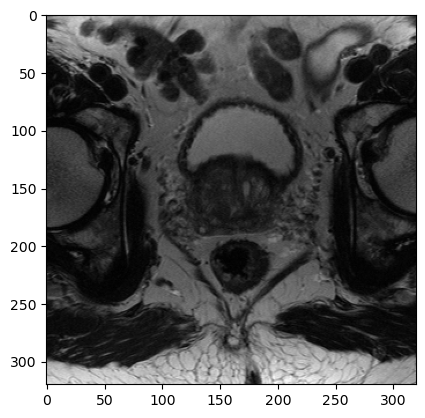

In [11]:
display_t2_slice(img_dict_t2['reconstruction_rss'], 10)

## DWI

This section outlines loading a file containing DWI raw kspace data along with the ismrmrd header for one sample from the dataset and performing reconstruction

In [12]:
with h5py.File(fname_dwi, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['adc_map', 'b1000x', 'b1000y', 'b1000z', 'b1500', 'b50x', 'b50y', 'b50z', 'calibration_data', 'coil_sens_maps', 'ismrmrd_header', 'kspace', 'phase_correction', 'trace_b1000', 'trace_b50']>


- DWI kspace has the following shape: (number of averages, number of slices, number of coils, height, width)
- DWI calibration kspace has the following shape: (number of slices, number of coils, height, calibration signal width) 
- ISMRMRD header contains metadata related to the scan 
- Coil sensitivity maps: (number of slices, number of coils, height, width)
- B50*, B1000*, trace, ADC reconstructed images with shape: (number of slices, cropped height, cropped width)

In [13]:
kspace_dwi, calibration_data_dwi, coil_sens_maps, hdr_dwi = load_file_dwi(fname_dwi)

In [14]:
kspace_dwi.shape, calibration_data_dwi.shape, coil_sens_maps.shape

((50, 30, 20, 200, 150), (30, 20, 200, 32), (30, 20, 200, 150))

The DWI reconstruction function takes as input DWI kspace, DWI calibration data, coil sensitivity maps along with the metadata and outputs a dictionary containing the reconstructed images

In [15]:
%%time
img_dict_dwi = dwi_reconstruction(kspace_dwi, calibration_data_dwi, coil_sens_maps, hdr_dwi)

CPU times: user 18min 41s, sys: 38.9 s, total: 19min 20s
Wall time: 5min 16s


In [16]:
img_dict_dwi.keys()

dict_keys(['b50x', 'b50y', 'b50z', 'b1000x', 'b1000y', 'b1000z', 'trace_b50', 'trace_b1000', 'adc_map', 'b1500'])

In [17]:
img_dict_dwi['b50x'].shape, img_dict_dwi['b1000x'].shape, img_dict_dwi['adc_map'].shape

((30, 100, 100), (30, 100, 100), (30, 100, 100))

Below, we plot the reconstructed images, which is the same as those present in the h5 file

In [18]:
def display_dwi_slice(dwi_recons, slice_num):
    _, ax = plt.subplots(2, 5, figsize=(12,5))
    
    for idx, k in enumerate(['b50x', 'b50y', 'b50z', 'trace_b50', 'adc_map']):
        ax[0][idx].imshow(img_dict_dwi[k][slice_num, :, :], cmap='gray')
        ax[0][idx].title.set_text(k)
    
    for idx, k in enumerate(['b1000x', 'b1000y', 'b1000z', 'trace_b1000', 'b1500']):
        ax[1][idx].imshow(img_dict_dwi[k][slice_num, :, :], cmap='gray')
        ax[1][idx].title.set_text(k)
        
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()


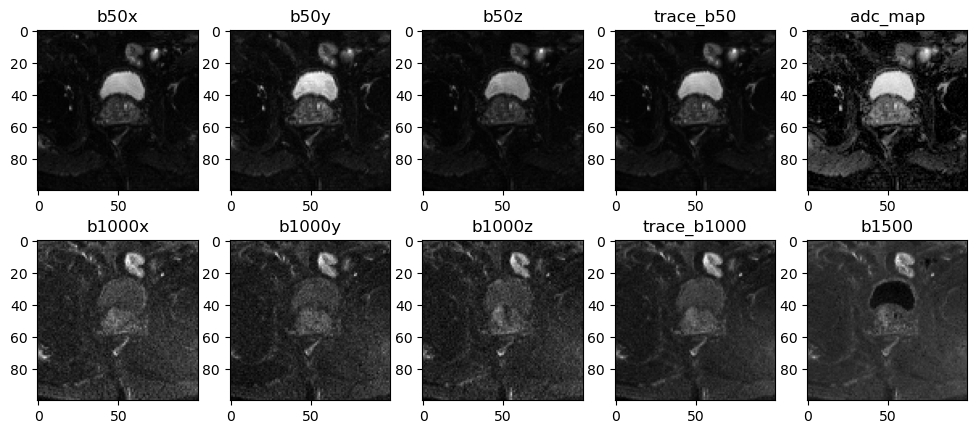

In [19]:
display_dwi_slice(img_dict_dwi, 10)